In [ ]:
import skimage.io as io
import cv2
import numpy as np
from zipfile import ZipFile
import pandas as pd
import torch

In [ ]:
file_name='labels/coco2017labels.zip'
with ZipFile(file_name, 'r') as zip:
#     bbox=zip.read('coco/labels/train2017/000000371735.txt')
#     box=(bbox.decode("utf-8"))
#     box=pd.DataFrame([x.split() for x in box.rstrip('\n').split('\n')],columns=['class','xc','yc','w','h'])
#     print(box)
    count = len(zip.infolist())
    print()

In [ ]:
from zipfile import ZipFile
file_name='labels/coco2017labels.zip'
zip_file = ZipFile(file_name)

dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()}

In [ ]:
import torch

a=torch.tensor([[[1,2,2,4,0,0,0,1],[2,3,5,3,0,0,1,0]]])
print(a.shape)
b=((a[:,:,4:]==1).nonzero())
b=b[:,-1].unsqueeze(0).unsqueeze(-1)
print(b.shape)
new=a[:,:,:4]
print(new.shape)
new=torch.cat((new.T,b.T)).T
print(new)
sorted_pred=torch.sort(new[0,:,4],descending=False)
print(sorted_pred)

In [ ]:
b = box.values.astype(np.float32)
b=torch.tensor(b)
labels = b.T[0].reshape(b.shape[0], 1)
one_hot_target = (labels == torch.arange(80).reshape(1, 80)).float()
conf=torch.ones([b.shape[0],1])
boxes=torch.cat((b.T[1:],conf.T,one_hot_target.T)).T




In [ ]:
file_name='images/train2017.zip'
with ZipFile(file_name, 'r') as zip:
    image=zip.read('train2017/000000408542.jpg')
    img = cv2.imdecode(np.frombuffer(image, np.uint8),1)
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    io.imshow(im_rgb)
    io.imsave('fig.png',im_rgb)

In [ ]:
df=pd.read_csv('pointers/train2017.txt',names=['filename'])

In [ ]:
df['box']=df['filename'].apply(lambda x: 'coco/labels/'+x.split('.')[0]+'.txt')

In [ ]:
df['box']

In [1]:
from dataset import *
import timeit 
import cv2
import numpy as np
from zipfile import ZipFile
import pandas as pd
import torch
import time
from darknet import *
import darknet as dn
import util as util
import torch.optim as optim

import sys
import timeit
import torch.autograd
import helper as helper
from torch.utils.tensorboard import SummaryWriter



net = Darknet("../cfg/yolov3.cfg")
inp_dim=net.inp_dim
pw_ph=net.pw_ph.to(device='cuda')
cx_cy=net.cx_cy.to(device='cuda')
stride=net.stride.to(device='cuda')


'''
when loading weights from dataparallel model then, you first need to instatiate the dataparallel model 
if you start fresh then first model.load_weights and then make it parallel
'''
try:
    PATH = '../pretrained.pth'
    weights = torch.load(PATH)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we https://pytorch.org/docs/stable/data.html#torch.utils.data.Datasetare on a CUDA machine, this should print a CUDA device:
    print(device)
    net.to(device)

    if torch.cuda.device_count() > 9:
        print("Using ", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(net)
        model.to(device)
        model.load_state_dict(weights)
    else:
        model=net
        model.to(device)
        model.load_state_dict(weights)
        
except FileNotFoundError: 
    net.load_weights("../yolov3.weights")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we are on a CUDA machine, this should print a CUDA device:

    print(device)
    net.to(device)
    if torch.cuda.device_count() > 1:
        print("Using ", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(net)
        model.to(device)
    else:
        model=net
        
        
transformed_dataset=Coco(partition='train',
                                           transform=transforms.Compose([
                                            ResizeToTensor(inp_dim)
                                           ]))


writer = SummaryWriter('../results/test')
dataset_len=(len(transformed_dataset))
print('Length of dataset is '+ str(dataset_len)+'\n')
batch_size=8

dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                        shuffle=True,collate_fn=helper.my_collate, num_workers=2)



optimizer = optim.SGD(model.parameters(), lr=0.0001, weight_decay=0.0005, momentum=0.9)

lambda1 = lambda epoch: 0.95**epoch
scheduler=optim.lr_scheduler.LambdaLR(optimizer, lambda1, last_epoch=-1)
epochs=50
total_loss=0
write=0
misses=0
break_flag=0
avg_iou=0
for e in range(epochs):
    prg_counter=0
    train_counter=0
    total_loss=0
    avg_iou=0
    avg_infs=0
    avg_conf=0
    avg_no_conf=0
    avg_pos=0
    avg_neg=0
    print("\n epoch "+str(e))
    misses=0
    for images,targets,img_names in dataloader:
        optimizer.zero_grad()
        targets,anchors,offset,strd,mask=helper.collapse_boxes(targets,pw_ph,cx_cy,stride)
        images=images.cuda()
        raw_pred = model(images, torch.cuda.is_available())
        raw_pred=helper.expand_predictions(raw_pred,mask)
        true_pred=util.transform(raw_pred.clone(),anchors,offset,strd)
        targets=targets.unsqueeze(-3)
        targets=targets.cuda()
        iou_mask,noobj_mask=util.get_responsible_masks(true_pred,targets,offset,strd,mask,inp_dim)
        
        iou1=torch.diag(util.bbox_iou(util.get_abs_coord(true_pred[iou_mask.T,:].unsqueeze(-3)),util.transpose_target(get_abs_coord(targets)*inp_dim)))
        iou=iou1.mean().item()
        noobj_box=raw_pred[:,:,4:5].clone()
        noobj_box=helper.uncollapse(noobj_box,mask)
        noobj_mask=helper.uncollapse(noobj_mask.T.unsqueeze(-1),mask)
        
        
        conf=raw_pred[iou_mask.T,:][:,4:5].mean().item()
        class_mask=targets[:,:,5:].type(torch.BoolTensor).squeeze(0)
        if(iou_mask.sum()==class_mask.shape[0]):
            pos_class=raw_pred[iou_mask.T,:][:,5:][class_mask].mean().item()
            neg_class=raw_pred[iou_mask.T,:][:,5:][~class_mask].mean().item()
        else:
            pos_class=0
            neg_class=0
        noobj_box=noobj_box[noobj_mask]
        no_obj_conf=noobj_box.mean().item()
        
        raw_pred=raw_pred[iou_mask.T,:]
        anchors=anchors[iou_mask.T,:]
        offset=offset[iou_mask.T,:]
        strd=strd[iou_mask.T,:]
        if(strd.shape[0]==sum(mask)):#this means that iou_mask failed and was all true, because max of zeros is true for all lenght of mask strd
            targets[:,:,0:4]=targets[:,:,0:4]*inp_dim
            targets=targets.squeeze(0)
            targets[:,0:4]=util.transform_groundtruth(targets,anchors,offset,strd)
            with torch.autograd.set_detect_anomaly(True):
                loss=util.yolo_loss(raw_pred,targets,noobj_box,mask)
                loss.backward()
                optimizer.step()
            
            avg_conf=avg_conf+conf
            avg_no_conf=avg_no_conf+no_obj_conf
            avg_pos=avg_pos+pos_class
            avg_neg=avg_neg+neg_class
            total_loss=total_loss+loss.item()
            avg_iou=avg_iou+iou
            sys.stdout.write('\rPgr:'+str(prg_counter/dataset_len*100*batch_size)+'%' ' L:'+ str(loss.item()))
            sys.stdout.write(' IoU:' +str(iou)+' pob:'+str(conf)+ ' nob:'+str(no_obj_conf))
            sys.stdout.write(' PCls:' +str(pos_class)+' ncls:'+str(neg_class))
            sys.stdout.flush()
            prg_counter=prg_counter+1
            train_counter=train_counter+1
        else:
            print('missed')
            print(strd.shape[0])
            prg_counter=prg_counter+1
        iou1=iou1.tolist()
        iou_per_class= [0] * 80
        averager_per_class=[1] * 80
        for i,el in enumerate(iou1):
            name=targets[i,5:].max(0)[1].cpu().detach().numpy()
            iou_per_class[name]=iou_per_class[name]+el
            averager_per_class[name]=averager_per_class[name]+1
        for i in range(80):
            if (iou_per_class[i]!=0):
                if i<40:
                    writer.add_scalar('Iou0/'+str(i), iou_per_class[i]/averager_per_class[i], train_counter)
                else:
                    writer.add_scalar('Iou1/'+str(i), iou_per_class[i]/averager_per_class[i], train_counter)
        writer.add_scalar('AvLoss/train', total_loss/train_counter, train_counter)

        
        writer.add_scalar('AvIoU/train', avg_iou/train_counter, train_counter)

        writer.add_scalar('AvPConf/train', avg_conf/train_counter, train_counter)
        
        writer.add_scalar('AvNConf/train', avg_no_conf/train_counter, train_counter)
        
        writer.add_scalar('AvClass/train', avg_pos/train_counter, train_counter)
        
        writer.add_scalar('AvNClass/train', avg_neg/train_counter, train_counter)
        
        del loss, raw_pred, targets, true_pred, images,iou,noobj_box,conf,iou1
        torch.cuda.empty_cache()
    if misses>0:
        break
#     torch.save(model.state_dict(), PATH)
#     writer.add_scalar('Loss/train', total_loss/train_counter, e)
#     writer.add_scalar('AIoU/train', avg_iou/train_counter, e)
#     writer.add_scalar('PConf/train', avg_conf/train_counter, e)
#     writer.add_scalar('NConf/train', avg_no_conf/train_counter, e)
#     writer.add_scalar('PClass/train', avg_pos/train_counter, e)
#     writer.add_scalar('NClass/train', avg_neg/train_counter, e)
    print('\ntotal number of misses is ' + str(misses))
    print('\n total average loss is '+str(total_loss/train_counter))
    print('\n total average iou is '+str(avg_iou/train_counter))

cuda:0
Using  2 GPUs!
Length of dataset is 118287


 epoch 0


/users/konsa15/.conda/envs/faster_rcnn/lib/python3.8/site-packages/torch/nn/functional.py:2503: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


Pgr:99.9940821899279% L:2.1205382347106934 IoU:0.7564195990562439 pob:0.49523231387138367 nob:0.0006193502340465784 PCls:0.8977230787277222 ncls:0.00129464420024305581556
total number of misses is 0

 total average loss is 2.113286115961792

 total average iou is 0.7594813029675462

 epoch 1
Pgr:51.339538579894665% L:1.9521749019622803 IoU:0.7833840250968933 pob:0.5720711946487427 nob:0.00022058552713133395 PCls:0.9273592829704285 ncls:0.000919503334444016256

KeyboardInterrupt: 

In [2]:
torch.save(model.state_dict(), PATH)

In [12]:
print(torch.exp(targets[:,2:4]))
wh=torch.exp(targets[:,2:4])
area=wh[:,0]*wh[:,1]
weights=torch.sigmoid(1/area).cuda()
print(weights)

tensor([[ 2.6239,  4.3937],
        [ 8.4988, 10.0201],
        [ 1.0580,  2.4166],
        [ 0.9973,  2.6048],
        [ 3.2327,  3.0643],
        [ 0.5482,  0.5809],
        [ 3.2654,  2.5082],
        [ 1.6980,  3.4301],
        [ 0.3344,  0.3726],
        [ 1.7152,  2.2961],
        [ 0.6986,  1.4767],
        [ 0.9299,  0.6364],
        [ 2.5822,  3.2134],
        [ 1.0680,  1.3578],
        [ 1.3028,  2.9742],
        [ 0.4619,  1.3526],
        [ 2.1216,  1.8432],
        [ 0.6065,  1.3174],
        [ 0.3986,  1.9597],
        [ 1.1533,  1.6773],
        [ 0.6278,  1.6535],
        [ 1.8403,  4.1132],
        [ 0.7894,  1.0318],
        [ 5.3638,  1.1324],
        [ 2.6491,  1.1525],
        [ 0.9253,  0.7233],
        [ 0.7345,  1.2702],
        [ 1.1153,  0.3788],
        [ 0.7916,  2.8667],
        [ 2.4124,  1.9173],
        [ 0.6108,  1.2117],
        [ 0.7077,  2.5864],
        [ 7.2755,  1.3777],
        [ 1.0825,  1.0979],
        [ 0.5145,  0.8254],
        [ 0.9801,  0

In [9]:
from sklearn import preprocessing
print(targets[:,5:].sum(axis=0))
print(mask)
print(sum(mask))
classes=targets[:,5:].max(1)[1]
print(classes)
idf=torch.log(sum(mask)/targets[:,5:].sum(axis=0))
idf[idf== float('inf')] = 0
print(idf)
print(idf[classes])

tf=[1/mask[i] for i in range(len(mask)) for j in range(mask[i])]
tf=torch.tensor([1/mask[i] for i in range(len(mask)) for j in range(mask[i])]).cuda()
tfidf=tf*idf[classes]
print(tfidf)

print(torch.softmax(tfidf,dim=0))


tensor([11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  4.,  1.,  0.,  0.,  1.,
         0.,  0.,  1.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  0.,
         2.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.], device='cuda:0')
[2, 4, 6, 8, 9, 2, 2, 6]
39
tensor([ 0, 38,  0,  0, 34,  0, 54, 54, 54, 54, 54, 63,  0,  0, 37, 37, 37, 37,
         0,  0, 72, 56,  0, 44, 45, 46, 46, 60, 69, 22, 22,  0, 36, 57,  0, 65,
        41, 73, 56], device='cuda:0')
tensor([1.2657, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 2.9704, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 3.66

In [ ]:
targets2,anchors,offset,strd,mask=helper.collapse_boxes(targets,pw_ph,cx_cy,stride)
transformed_output=true_pred
targets=targets
offset=offset
strd=strd
mask=mask
inp_dim
'''
this function takes the transformed_output and
the target box in respect to the resized image size
and returns a mask which can be applied to select the 
best raw input,anchors and cx_cy_offset
and the noobj_mask for the negatives
targets is a list
'''
#first transpose the centered normalised target coords
centered_target=transpose_target(targets)[:,:,0:2]
#multiply by inp_dim then devide by stride to get the relative grid size coordinates, floor the result to get the corresponding cell
centered_target=torch.floor(centered_target*inp_dim/strd)
#create a mask to find where the gt falls into which gridcell in the grid coordinate system
fall_into_mask=centered_target==offset
fall_into_mask=fall_into_mask[:,:,0]&fall_into_mask[:,:,1]
#     fall_into_mask= ~fall_into_mask
#create a copy of the transformed output
best_bboxes=transformed_output.clone()
#apply reverse mask to copy in order to zero all other bbox locations
best_bboxes[~fall_into_mask]=0   
#transform the copy to xmin,xmax,ymin,ymax
best_responsible_coord=get_abs_coord(best_bboxes)
targets=transpose_target(get_abs_coord(targets))*inp_dim
#calculate best iou and mask
responsible_iou=bbox_iou(best_responsible_coord,targets,True)

responsible_iou[responsible_iou.ne(responsible_iou)] = 0
responsible_mask=responsible_iou.max(dim=0)[0] == responsible_iou

print(responsible_mask.shape)

abs_coord=get_abs_coord(transformed_output)
iou=bbox_iou(abs_coord,targets,True)
iou[iou.ne(iou)] = 0
ignore_mask=0.5<=iou
inverted_mask=iou.max(dim=0)[0] != iou
noobj_mask=~same_picture_mask(responsible_mask.clone()|ignore_mask,mask)

In [ ]:
print(responsible_mask)
if(responsible_mask.sum()>sum(mask)):
    print('jello')
    responsible_mask1=correct_iou_mask(responsible_mask,fall_into_mask)
print(responsible_mask1.shape)

In [ ]:
a=torch.randint(0, 9, (1,)) == torch.arange(9)
a=a.repeat(5)
a=a.repeat(2,1)
print(a)
print(a.T)

In [ ]:
le_mask=(responsible_mask.sum(axis=0)==responsible_mask.sum(axis=0).max())

In [ ]:
responsible_mask[:,le_mask]=(responsible_mask[:,le_mask]&fall_into_mask[le_mask,:].T)

In [ ]:
print(le_mask)
print(fall_into_mask[le_mask,:].shape)


In [ ]:
a=torch.tensor([1,2,3,4,5,6,6,6])
indices=(((a==a.max())==True).nonzero())
for ind in indices:
    print(ind)

In [2]:
from darknet import *
import darknet as dn
import util as util
import torch.optim as optim
import pandas as pd
import time
import sys
import timeit
from dataset import *
import torchvision.ops.boxes as nms_box
import helper as helper
from utils import *
from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes


net = Darknet("../cfg/yolov3.cfg")
inp_dim=net.inp_dim
pw_ph=net.pw_ph
cx_cy=net.cx_cy
stride=net.stride


'''
when loading weights from dataparallel model then, you first need to instatiate the dataparallel model 
if you start fresh then first model.load_weights and then make it parallel
'''
try:
    PATH = '../pretrained.pth'
    weights = torch.load(PATH)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we are on a CUDA machine, this should print a CUDA device:
    print(device)
    net.to(device)

    if torch.cuda.device_count() > 1:
        print("Using ", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(net)
    else:
        model=net

    model.to(device)
    
    
    model.load_state_dict(weights)
    model.eval()
except FileNotFoundError: 
    net.load_weights("../yolov3.weights")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Assuming that we are on a CUDA machine, this should print a CUDA device:

    print(device)
    net.to(device)
    if torch.cuda.device_count() > 1:
      print("Using ", torch.cuda.device_count(), "GPUs!")
      model = nn.DataParallel(net)

    model.to(device)
    model.eval()




print('testing with '+ PATH +'\n')
transformed_dataset=Coco(partition='val',
                                           transform=transforms.Compose([
                                            ResizeToTensor(inp_dim)
                                           ]))



dataset_len=(len(transformed_dataset))
print('Length of dataset is '+ str(dataset_len)+'\n')
batch_size=8

dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                        shuffle=True,collate_fn=helper.my_collate, num_workers=2)

true_pos=0
false_pos=0
counter=0
iou_threshold=0.5
confidence=0.01
recall_counter=0

for images,targets,img_name in dataloader:
    inp=images.cuda()
    raw_pred = model(inp, torch.cuda.is_available())
    targets,anchors,offset,strd,mask=helper.collapse_boxes(targets,pw_ph,cx_cy,stride)
    raw_pred=raw_pred.to(device='cuda')
    true_pred=util.transform(raw_pred.clone(),pw_ph,cx_cy,stride)
    
    classes=true_pred[:,:,5:].max(2)[0]
    objectness=true_pred[:,:,4]
    
    sorted_pred=torch.sort(objectness,descending=True)
    pred_mask=sorted_pred[0]>confidence
    indices=[(sorted_pred[1][e,:][pred_mask[e,:]]) for e in range(pred_mask.shape[0])]
    pred_final=[true_pred[i,indices[i],:] for i in range(len(indices))]
    
    pred_final_coord=[util.get_abs_coord(pred_final[i].unsqueeze(-2)) for i in range(len(pred_final))]
    
    indices=[nms_box.nms(pred_final_coord[i][0],pred_final[i][:,4],iou_threshold) for i in range(len(pred_final))]

    pred_final=[pred_final[i][indices[i],:] for i in range(len(pred_final))]
#     pred_final[:,0:4]=pred_final[:,0:4]/inp_dim
    helper.write_pred(img_name,pred_final,inp_dim)
    

    
# Read txt files containing bounding boxes (ground truth and detections)


cuda:0
Using  2 GPUs!
testing with ../pretrained.pth

Length of dataset is 5000



/users/konsa15/.conda/envs/faster_rcnn/lib/python3.8/site-packages/torch/nn/functional.py:2503: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


In [ ]:
from darknet import *
import darknet as dn
import util as util
import torch.optim as optim
import pandas as pd
import time
import sys
import timeit
from dataset import *
import torchvision.ops.boxes as nms_box
import helper as helper
from utils import *
from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes
boundingboxes = helper.getBoundingBoxes()


In [5]:
from Evaluator import *
from utils import *
from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes


boundingboxes = helper.getBoundingBoxes()

evaluator = Evaluator()

iou=0.05
MMap=0
while iou<0.95:
    metricsPerClass = evaluator.GetPascalVOCMetrics(boundingboxes, IOUThreshold=iou)
#     print("Average precision values per class:\n")
    # Loop through classes to obtain their metrics
    mAP=0
    counter=0
    for mc in metricsPerClass:
        # Get metric values per each class
        c = mc['class']
        precision = mc['precision']
        recall = mc['recall']
        average_precision = mc['AP']
        ipre = mc['interpolated precision']
        irec = mc['interpolated recall']
        # Print AP per class
        mAP=average_precision+mAP
#         print('%s: %f' % (c, average_precision))
    MMap=MMap+mAP/80
    iou=iou+0.05
    print('\nCOCO map is:',MMap)


COCO map is: 0.6697134191784458

COCO map is: 1.3352560992330769

COCO map is: 1.9964744098491396

COCO map is: 2.653250136699156

COCO map is: 3.3056622952264365

COCO map is: 3.951772607448092

COCO map is: 4.589426216164657

COCO map is: 5.216961243164041

COCO map is: 5.832269768213639

COCO map is: 6.4300187989023545

COCO map is: 7.00296698428485

COCO map is: 7.540756813394808

COCO map is: 8.031861349906901

COCO map is: 8.464277006412278

COCO map is: 8.817369154686132

COCO map is: 9.074098803584556

COCO map is: 9.21308321890343

COCO map is: 9.254349068108349


In [6]:
for mc in metricsPerClass:
    c = mc['class']
    average_precision = mc['AP']
    print('%s: %f' % (c, average_precision))

0: 0.044080
1: 0.018950
10: 0.083119
11: 0.099939
12: 0.079374
13: 0.029754
14: 0.019329
15: 0.116021
16: 0.093195
17: 0.063567
18: 0.051430
19: 0.067876
2: 0.027003
20: 0.087345
21: 0.230473
22: 0.079109
23: 0.091553
24: 0.000512
25: 0.019484
26: 0.002928
27: 0.014346
28: 0.021513
29: 0.033620
3: 0.014385
30: 0.005631
31: 0.000630
32: 0.024367
33: 0.023056
34: 0.003730
35: 0.033894
36: 0.008477
37: 0.012159
38: 0.024032
39: 0.014296
4: 0.112498
40: 0.014734
41: 0.046908
42: 0.017874
43: 0.010425
44: 0.007936
45: 0.041454
46: 0.015823
47: 0.018162
48: 0.062845
49: 0.036478
5: 0.195222
50: 0.004256
51: 0.002300
52: 0.031162
53: 0.070215
54: 0.024261
55: 0.027452
56: 0.009959
57: 0.103516
58: 0.007340
59: 0.081101
6: 0.124600
60: 0.068044
61: 0.088627
62: 0.061185
63: 0.096142
64: 0.008939
65: 0.004051
66: 0.057793
67: 0.018215
68: 0.050436
69: 0.015009
7: 0.030365
70: 0.000000
71: 0.021644
72: 0.073670
73: 0.001596
74: 0.012959
75: 0.027426
76: 0.008547
77: 0.039591
78: 0.000000
79: 0.0

In [7]:
print(MMap/19)

0.48707100358464994


In [7]:
print('%s: %f' % (c, average_precision))

9: 0.000231


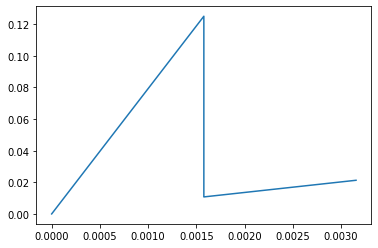

In [4]:
import matplotlib.pyplot as plt

plt.plot(recall, precision)

In [ ]:
from Evaluator import *
evaluator = Evaluator()
metricsPerClass = evaluator.GetPascalVOCMetrics(boundingboxes, IOUThreshold=0.5)
print("Average precision values per class:\n")
# Loop through classes to obtain their metrics
mAP=0
counter=0
for mc in metricsPerClass:
    # Get metric values per each class
    c = mc['class']
    precision = mc['precision']
    recall = mc['recall']
    average_precision = mc['AP']
    ipre = mc['interpolated precision']
    irec = mc['interpolated recall']
    # Print AP per class
    mAP=average_precision+mAP
    print('%s: %f' % (c, average_precision))

print('map is:',mAP/80)

In [ ]:
0.07290217209136615

In [ ]:
import pandas as pd
coord=pred_final[:,:4].cpu().detach().numpy()
conf=pred_final[:,4:5].cpu().detach().numpy()
mat=np.hstack((conf,coord))

classes=pred_final[:,5:].max(1)[1].cpu().detach().numpy()
classes=np.array([classes]).T

mat=np.hstack((classes,mat))
mat=np.array(mat)

df=pd.DataFrame(mat,index=None,columns=None)
df[0]=df[0].apply(lambda x: int(x))

df.to_csv('test.txt',sep=' ',header=False,index=None)

In [ ]:
np.savetxt('test.txt',mat)

In [ ]:
a=torch.tensor([1,2,2,3,4,2,3,1,4])
print(a.max(0))

In [ ]:
import skimage.io as io

In [ ]:
image=(inp).squeeze(0)
image=np.array(image.cpu())
print(image.shape)
image =  image[:,:,::-1].transpose((1,2,0))
print(image.shape)

In [ ]:
import pandas as pd
import glob

all_files = glob.glob('plots/' + "/*.csv")

li = []

for filename in sorted(all_files):
    print(filename)
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=1, ignore_index=True)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# gca stands for 'get current axis'

title_list=['AIoU_train','Loss_train','NClass_train','NConf_train','PClass','PConf']

fig = plt.figure(figsize=(30, 10))
fig.suptitle('KL for xy loss')
fig.subplots_adjust(hspace=0.3, wspace=-.6)
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
i=2
k=0
while i <18:
    ax = fig.add_subplot(2, 9, i)
    frame.plot(x =1 , y = i,ax=ax,legend=False)
    ax.set_title(title_list[k])
    i=i+3
    k=k+1
plt.savefig('original.png')
plt.show()